In [172]:
import pickle
import random
import math
import warnings
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [173]:
PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban_weather.pkl'
OUTPUT_TREE_PATH = '../products/decision_tree/decision_tree_{0}.dot'
MAX_DT_DEPTH = 3

In [174]:
from sklearn.model_selection import KFold
from sklearn import tree, metrics

def train_test_split(X, n_splits=5):
    '''
    Splits rows into training indices and test indices.
    :param X: numpy array of training data, e.g.  np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) - each sample has two features
    :return: Returns indices of rows for train and test for n_splits. e.g. n_splits=2: 
    train_folds = [[0,2,3], [1,2,3]] test_folds = [[1], [0]] 
    '''

    kf = KFold(n_splits=n_splits, random_state=2346, shuffle=True)
    kf.get_n_splits(X)
    
    train_folds, test_folds = [], []
    
    for train_index, test_index in kf.split(X):
        train_folds.append(train_index)
        test_folds.append(test_index)
    
    return train_folds, test_folds


def decision_tree_train(X_train, y_train):
    dt = tree.DecisionTreeRegressor(max_depth=MAX_DT_DEPTH)
    trained_model = dt.fit(X_train, y_train)
    return trained_model


def linear_regression_train(X_train, y_train):
    regr = sklearn.linear_model.LinearRegression()
    trained_model = regr.fit(X_train, y_train)
    return trained_model

###### Prepare data

Some of the 'first_7' rows are nans (for samples where n>20 but 7 days have not passed)

Some of the Province_State are nans (Not all countries have provinces)

In [176]:
hopkins_confirmed = pd.read_pickle(PICKLE_PATH)
nan_countries = []
nan_first_7 = []
for column in hopkins_confirmed.columns:
    any_nan = hopkins_confirmed[column].loc[:, 'data'].isna().any()
    nulls = hopkins_confirmed[column].loc[:, 'data'].isna().tolist()
    if any_nan:
        size = len([nul for nul in nulls if nul])
        print('{0}: {1}, {2}'.format(column, any_nan, size))
        for i in range(len(nulls)):
            if column == 'Country_Region':
                nc = hopkins_confirmed['Country_Region'].index[i][0]
                nan_countries.append(nc)
            if column == 'first_7':
                nc = hopkins_confirmed['first_7'].index[i][0]
                nan_first_7.append(nc)
# hopkins_confirmed.drop(nan_first_7, level=0, inplace=True) # This was removed because it was buggy. the dropna is better and robust
hopkins_confirmed['Province_State'] = hopkins_confirmed['Province_State'].fillna('')
hopkins_confirmed.dropna(inplace=True)

Province_State: True, 137
first_7: True, 7


Normalize first_7

In [177]:
hopkins_confirmed['first_7'] = ((hopkins_confirmed['first_7'] + 1) ** (1/7) - 1)

In [178]:
hopkins_confirmed.describe()

,GDP,Urbanization,avg_m_tmp,avg_m_RH,avg_m_precip,avg_m_wind,Max_Cases,first_7,avg_interval_tmp,avg_interval_RH,...,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,52090.890353,74.345655,9.437621,70.902462,1.787219,11.821452,1697.803387,0.202362,12.756306,70.007057,...,801.333020,877.954845,973.146754,1065.435560,1168.716839,1275.482596,1402.503293,1498.430856,1593.976482,1697.771402
std,21121.453292,14.627599,7.605476,9.057977,1.680550,3.679917,14993.072453,0.078129,7.358585,10.131658,...,6814.353811,7483.586652,8312.659775,9136.641046,10074.017100,11074.739093,12233.869566,13114.647699,14028.638112,14993.075916
min,396.000000,14.338000,-16.824675,11.831169,0.000000,3.007246,20.000000,0.000000,-9.926087,8.444444,...,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000,17.000000
25%,46609.000000,66.300000,3.940260,66.883117,0.032987,9.331169,37.000000,0.152888,6.837778,66.533333,...,11.000000,13.000000,16.000000,18.000000,21.000000,23.500000,27.000000,30.500000,33.000000,37.000000
50%,55172.000000,75.100000,8.459740,72.558442,1.604928,11.415152,88.000000,0.203955,11.987500,71.666667,...,28.000000,33.000000,38.000000,44.000000,51.000000,58.000000,66.000000,73.000000,79.000000,88.000000
75%,61594.000000,86.200000,13.906494,76.493506,2.681688,14.015584,308.500000,0.258499,17.919048,76.281746,...,118.000000,135.000000,152.000000,173.500000,203.500000,222.000000,251.000000,265.500000,286.000000,308.500000
max,200277.000000,100.000000,32.323377,88.608696,7.818052,29.774026,396223.000000,0.426162,35.100000,94.000000,...,140909.000000,161837.000000,188172.000000,213372.000000,243616.000000,275586.000000,308850.000000,337072.000000,366667.000000,396223.000000


Discard outlier data

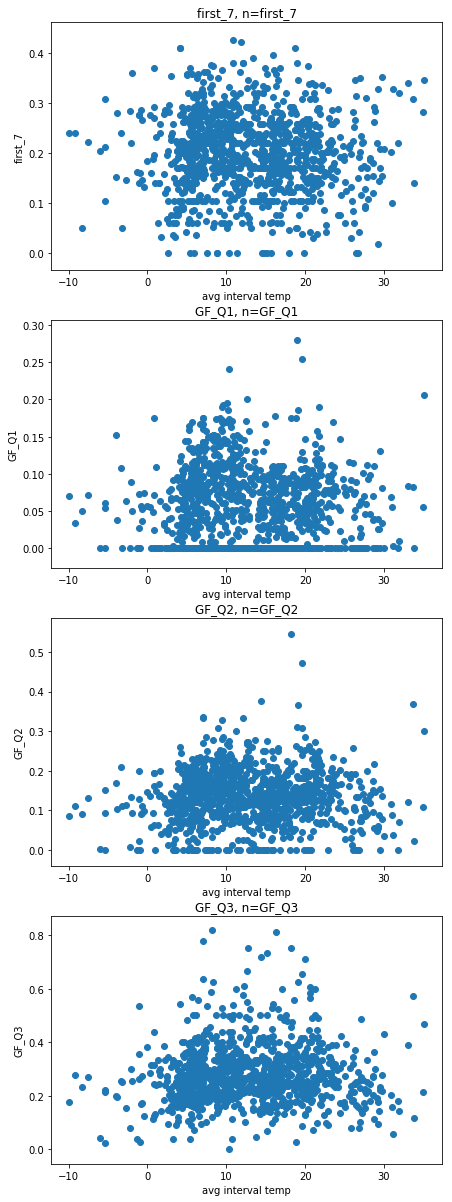

In [179]:
target_columns = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
avg_tmp = hopkins_confirmed[['Country_Region', 'avg_interval_tmp']].copy()
gf = hopkins_confirmed[target_columns].copy()

fig, axes = plt.subplots(4, 1, figsize=(7, 21))

for i in range(len(target_columns)):
    avg_int_tmp = avg_tmp['avg_interval_tmp'].values
    _ = axes[i].scatter(avg_int_tmp, gf[gf.columns[i]].values)
    n = len(avg_tmp['avg_interval_tmp'])
    _ = axes[i].set_xlabel('avg interval temp')
    _ = axes[i].set_ylabel(gf.columns[i])
    _ = axes[i].set_title('{0}, n={0}'.format(gf.columns[i], n))

#     countries = hopkins_confirmed['Country_Region'].loc[:,'data'].values.tolist()
#     for q, txt in enumerate(countries):
#         _ = axes[i].annotate(txt, (avg_int_tmp[q], gf[gf.columns[i]].values[q]))


###### Regression and decision tree - No thresholds

###### Regression

In [180]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
regr_rslt = pd.DataFrame(index=idx)
for col in label_cols:
    regr_rslt[col] = np.nan

model_fn = linear_regression_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0]
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr_trained = model_fn(X_train, y_train)

        # evaluate on test
        y_pred = regr_trained.predict(X_test)
        regr_rslt.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = regr_trained.predict(X_train)
        regr_rslt.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        regr_rslt.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
regr_rslt

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005259  0.001668  0.004394  0.015653
    train  0.005585  0.001748  0.003395  0.009764
    naive  0.005352  0.001713  0.004435  0.016504
2   test   0.005607  0.001738  0.003209  0.010715
    train  0.005494  0.001731  0.003691  0.010995
    naive  0.005607  0.001788  0.003329  0.011336
3   test   0.004871  0.002023  0.003111  0.009537
    train  0.005681  0.001663  0.003725  0.011305
    naive  0.004844  0.002134  0.003400  0.010319
4   test   0.005743  0.001677  0.003829  0.009169
    train  0.005461  0.001747  0.003537  0.011401
    naive  0.005712  0.001724  0.004059  0.009266
5   test   0.006387  0.001740  0.003628  0.010182
    train  0.005314  0.001744  0.003592  0.011125
    naive  0.006286  0.001686  0.003625  0.010855

##### Decision tree

In [181]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
dt_rslt = pd.DataFrame(index=idx)
for col in label_cols:
    dt_rslt[col] = np.nan

model_fn = decision_tree_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0]
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
    
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt_trained = model_fn(X_train, y_train)
        if model_fn == decision_tree_train: 
            # tree.plot_tree(dt_trained, feature_names=feature_cols)
            suffix = label_col + '_run' + str(train_test_round)
            _ = tree.export_graphviz(dt_trained, OUTPUT_TREE_PATH.format(suffix), feature_names=feature_cols) # dot -Tpng tree.dot -o tree.png 
        # evaluate on test
        y_pred = dt_trained.predict(X_test)
        dt_rslt.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = dt_trained.predict(X_train)
        dt_rslt.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        dt_rslt.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
dt_rslt

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005241  0.001869  0.004278  0.014094
    train  0.005320  0.001509  0.003095  0.008468
    naive  0.005352  0.001713  0.004435  0.016504
2   test   0.005606  0.001730  0.003292  0.009269
    train  0.005259  0.001528  0.003280  0.009698
    naive  0.005607  0.001788  0.003329  0.011336
3   test   0.004841  0.001931  0.003000  0.009942
    train  0.005423  0.001451  0.003269  0.009785
    naive  0.004844  0.002134  0.003400  0.010319
4   test   0.005787  0.001621  0.004056  0.008483
    train  0.005149  0.001494  0.003071  0.009836
    naive  0.005712  0.001724  0.004059  0.009266
5   test   0.006253  0.001717  0.003496  0.010170
    train  0.004954  0.001577  0.003144  0.009619
    naive  0.006286  0.001686  0.003625  0.010855

In [152]:
!dot -Tpng ../products/decision_tree/decision_tree_GF_Q1_run4.dot -o tree.png && open ../products/decision_tree/tree.png

###### Regr and tree - thresholds

In [182]:
GDP_THRESHOLD = 43000
URB_THRESHOLD = 88
    # MEAN   - 22914, 67
    # USA    - 62794, 82
    # ISRAEL - 41715, 92
    # FRANCE - 41463, 80

data = hopkins_confirmed[hopkins_confirmed['GDP'] >= GDP_THRESHOLD]\
                        [hopkins_confirmed['Urbanization'] >= URB_THRESHOLD]
    
print('Locations in entire dataset: {0}\n'
      'Location after thresholds: {1}'.format(len(hopkins_confirmed), len(data)))

Locations in entire dataset: 1063
Location after thresholds: 175


###### Regr

In [183]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
regr_rslt_thrs = pd.DataFrame(index=idx)
for col in label_cols:
    regr_rslt_thrs[col] = np.nan

model_fn = linear_regression_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0]
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr_trained = model_fn(X_train, y_train)

        # evaluate on test
        y_pred = regr_trained.predict(X_test)
        regr_rslt_thrs.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = regr_trained.predict(X_train)
        regr_rslt_thrs.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        regr_rslt_thrs.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
regr_rslt_thrs

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005259  0.001668  0.004394  0.015653
    train  0.005585  0.001748  0.003395  0.009764
    naive  0.005352  0.001713  0.004435  0.016504
2   test   0.005607  0.001738  0.003209  0.010715
    train  0.005494  0.001731  0.003691  0.010995
    naive  0.005607  0.001788  0.003329  0.011336
3   test   0.004871  0.002023  0.003111  0.009537
    train  0.005681  0.001663  0.003725  0.011305
    naive  0.004844  0.002134  0.003400  0.010319
4   test   0.005743  0.001677  0.003829  0.009169
    train  0.005461  0.001747  0.003537  0.011401
    naive  0.005712  0.001724  0.004059  0.009266
5   test   0.006387  0.001740  0.003628  0.010182
    train  0.005314  0.001744  0.003592  0.011125
    naive  0.006286  0.001686  0.003625  0.010855

###### dt

In [184]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
dt_rslt_thrs = pd.DataFrame(index=idx)
for col in label_cols:
    dt_rslt_thrs[col] = np.nan

model_fn = decision_tree_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0]
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
    
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt_trained = model_fn(X_train, y_train)
        if model_fn == decision_tree_train: 
            # tree.plot_tree(dt_trained, feature_names=feature_cols)
            suffix = label_col + '_run' + str(train_test_round)
            _ = tree.export_graphviz(dt_trained, OUTPUT_TREE_PATH.format(suffix), feature_names=feature_cols) # dot -Tpng tree.dot -o tree.png 
        # evaluate on test
        y_pred = dt_trained.predict(X_test)
        dt_rslt_thrs.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = dt_trained.predict(X_train)
        dt_rslt_thrs.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        dt_rslt_thrs.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
dt_rslt_thrs

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005241  0.001869  0.004278  0.014094
    train  0.005320  0.001509  0.003095  0.008468
    naive  0.005352  0.001713  0.004435  0.016504
2   test   0.005606  0.001730  0.003292  0.009269
    train  0.005259  0.001528  0.003280  0.009698
    naive  0.005607  0.001788  0.003329  0.011336
3   test   0.004841  0.001931  0.003000  0.009942
    train  0.005423  0.001451  0.003269  0.009785
    naive  0.004844  0.002134  0.003400  0.010319
4   test   0.005787  0.001621  0.004056  0.008483
    train  0.005149  0.001494  0.003071  0.009836
    naive  0.005712  0.001724  0.004059  0.009266
5   test   0.006253  0.001717  0.003496  0.010170
    train  0.004954  0.001577  0.003144  0.009619
    naive  0.006286  0.001686  0.003625  0.010855

In [ ]:
!dot -Tpng ../products/decision_tree/decision_tree_GF_Q1_run4.dot -o tree.png && open ../products/decision_tree/tree.png

###### Only US 

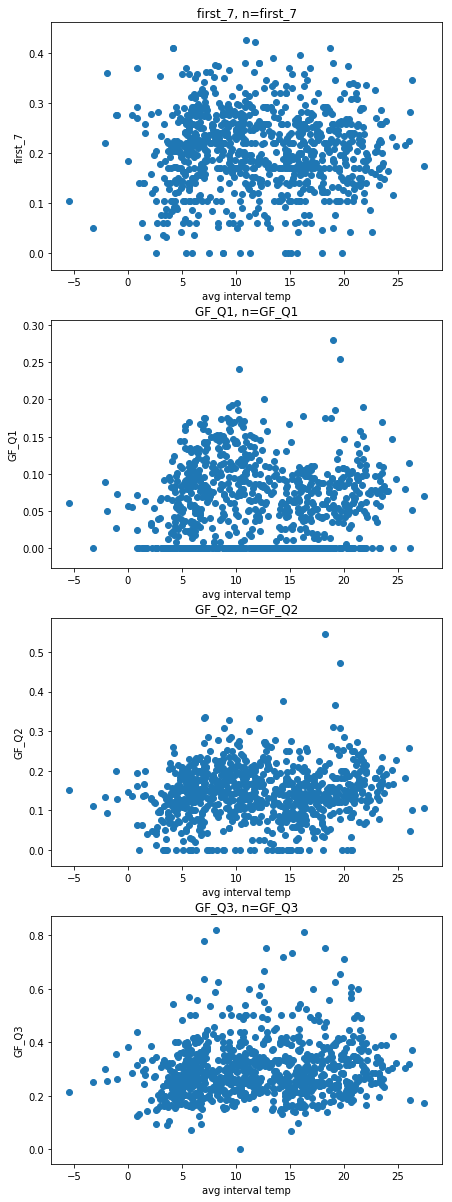

In [185]:
target_columns = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
avg_tmp = hopkins_confirmed[['Country_Region', 'avg_interval_tmp']].copy()[hopkins_confirmed['Country_Region'] =='US']
gf = hopkins_confirmed[target_columns].copy()[hopkins_confirmed['Country_Region'] =='US']

fig, axes = plt.subplots(4, 1, figsize=(7, 21))

for i in range(len(target_columns)):
    avg_int_tmp = avg_tmp['avg_interval_tmp'].values
    _ = axes[i].scatter(avg_int_tmp, gf[gf.columns[i]].values)
    n = len(avg_tmp['avg_interval_tmp'])
    _ = axes[i].set_xlabel('avg interval temp')
    _ = axes[i].set_ylabel(gf.columns[i])
    _ = axes[i].set_title('{0}, n={0}'.format(gf.columns[i], n))

#     states = hopkins_confirmed[hopkins_confirmed['Country_Region'] =='US']['Province_State'].loc[:,'data'].values.tolist()
#     for q, txt in enumerate(states):
#         _ = axes[i].annotate(txt, (avg_int_tmp[q], gf[gf.columns[i]].values[q]))


###### Regression

In [186]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
regr_rslt = pd.DataFrame(index=idx)
for col in label_cols:
    regr_rslt[col] = np.nan

model_fn = linear_regression_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0][hopkins_confirmed['Country_Region'] =='US']
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr_trained = model_fn(X_train, y_train)

        # evaluate on test
        y_pred = regr_trained.predict(X_test)
        regr_rslt.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = regr_trained.predict(X_train)
        regr_rslt.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        regr_rslt.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
regr_rslt

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005297  0.001741  0.002861  0.009841
    train  0.005530  0.001813  0.003810  0.010889
    naive  0.005361  0.001808  0.002806  0.009960
2   test   0.004868  0.001889  0.003031  0.009486
    train  0.005650  0.001772  0.003756  0.010975
    naive  0.004888  0.001933  0.003118  0.009348
3   test   0.004855  0.001668  0.004466  0.010264
    train  0.005644  0.001827  0.003408  0.010772
    naive  0.004872  0.001677  0.004631  0.010424
4   test   0.005789  0.001658  0.004439  0.011586
    train  0.005409  0.001832  0.003416  0.010467
    naive  0.005759  0.001674  0.004471  0.011573
5   test   0.006878  0.002114  0.003533  0.012855
    train  0.005142  0.001715  0.003630  0.010142
    naive  0.006868  0.002206  0.003641  0.013393

###### DT

In [187]:
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
arrays = [[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5],\
          ['test','train','naive','test','train','naive','test','train',\
           'naive','test','train','naive','test','train','naive']]
idx = pd.MultiIndex.from_arrays(arrays, names=('run', 'mse'))
dt_rslt_thrs = pd.DataFrame(index=idx)
for col in label_cols:
    dt_rslt_thrs[col] = np.nan

model_fn = decision_tree_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    data = hopkins_confirmed.copy()[hopkins_confirmed[label_col] > 0][hopkins_confirmed['Country_Region'] =='US']
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
    
#     print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt_trained = model_fn(X_train, y_train)
        if model_fn == decision_tree_train: 
            # tree.plot_tree(dt_trained, feature_names=feature_cols)
            suffix = label_col + '_run' + str(train_test_round)
            _ = tree.export_graphviz(dt_trained, OUTPUT_TREE_PATH.format(suffix), feature_names=feature_cols) # dot -Tpng tree.dot -o tree.png 
        # evaluate on test
        y_pred = dt_trained.predict(X_test)
        dt_rslt_thrs.loc[train_test_round + 1, 'test'][label_col] = metric_fn(y_test, y_pred)

        # Compare to train data
        y_pred_train = dt_trained.predict(X_train)
        dt_rslt_thrs.loc[train_test_round + 1, 'train'][label_col] = metric_fn(y_train, y_pred_train)
               
        # Compare to a naive mean-value model:
        y_pred_naive = np.ndarray(y_pred.shape)
        y_pred_naive.fill(y_train.mean())
        dt_rslt_thrs.loc[train_test_round + 1, 'naive'][label_col] = metric_fn(y_test, y_pred_naive)
dt_rslt_thrs

first_7     GF_Q1     GF_Q2     GF_Q3
run mse                                          
1   test   0.005951  0.001933  0.002769  0.009483
    train  0.004936  0.001582  0.003284  0.010049
    naive  0.005361  0.001808  0.002806  0.009960
2   test   0.004956  0.001932  0.002908  0.011119
    train  0.005356  0.001532  0.003288  0.009682
    naive  0.004888  0.001933  0.003118  0.009348
3   test   0.005166  0.001817  0.004200  0.010417
    train  0.005185  0.001599  0.002974  0.009799
    naive  0.004872  0.001677  0.004631  0.010424
4   test   0.006223  0.001689  0.004116  0.011492
    train  0.004882  0.001619  0.002987  0.009706
    naive  0.005759  0.001674  0.004471  0.011573
5   test   0.007282  0.002016  0.003477  0.012406
    train  0.004688  0.001492  0.003152  0.009403
    naive  0.006868  0.002206  0.003641  0.013393

In [ ]:
!dot -Tpng ../products/decision_tree/decision_tree_GF_Q1_run4.dot -o tree.png && open ../products/decision_tree/tree.png